<a href="https://colab.research.google.com/github/anhdo1896/Stock_Price_Prediction_Using_RNN/blob/main/Stock_Price_Prediction_Using_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"


# Common imports
import numpy as np
import os, time
import pandas as pd
import pandas_datareader as pdr
import datetime as dt
import yfinance as yf
yf.pdr_override()

# Deep Learning imports
import tensorflow as tf
import keras

# To plot nice figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
mpl.rc('figure', dpi=100)
import seaborn as sns; sns.set()

# Check the versions are OK (both should be 2 or more)
print(tf.__version__)
print(keras.__version__)
print(tf.config.list_physical_devices('GPU'))

2.14.0
2.14.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
company = 'GOOG'
startdate = dt.datetime(2012, 1, 1)
enddate = dt.datetime(2023, 11, 14)
df = yf.download(company, start=startdate, end=enddate)

[*********************100%%**********************]  1 of 1 completed


In [3]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,16.262545,16.641375,16.248346,16.573130,16.573130,147611217
2012-01-04,16.563665,16.693678,16.453827,16.644611,16.644611,114989399
2012-01-05,16.491436,16.537264,16.344486,16.413727,16.413727,131808205
2012-01-06,16.417213,16.438385,16.184088,16.189817,16.189817,108119746
2012-01-09,16.102144,16.114599,15.472754,15.503389,15.503389,233776981


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2986 entries, 2012-01-03 to 2023-11-13
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2986 non-null   float64
 1   High       2986 non-null   float64
 2   Low        2986 non-null   float64
 3   Close      2986 non-null   float64
 4   Adj Close  2986 non-null   float64
 5   Volume     2986 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 163.3 KB


In [5]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2986.000000,2986.000000,2986.000000,2986.000000,2986.000000,2.986000e+03
mean,59.872157,60.503521,59.278231,59.904568,59.904568,4.405541e+07
std,38.206686,38.674171,37.787105,38.232069,38.232069,3.517904e+07
min,13.956189,14.060299,13.861045,13.924059,13.924059,1.584340e+05
25%,28.092996,28.322968,27.843880,28.015511,28.015511,2.427950e+07
50%,51.017250,51.711500,50.470499,51.064749,51.064749,3.186000e+07
75%,86.916624,88.195000,86.262127,87.000751,87.000751,5.132904e+07
max,151.863495,152.100006,149.887497,150.709000,150.709000,4.995615e+08


In [6]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [7]:
df.shape

(2986, 6)

In [8]:
df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [9]:
df.dtypes

Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [10]:
data = df.loc[:,["Open"]].values
data = data.reshape(data.shape[0],1)

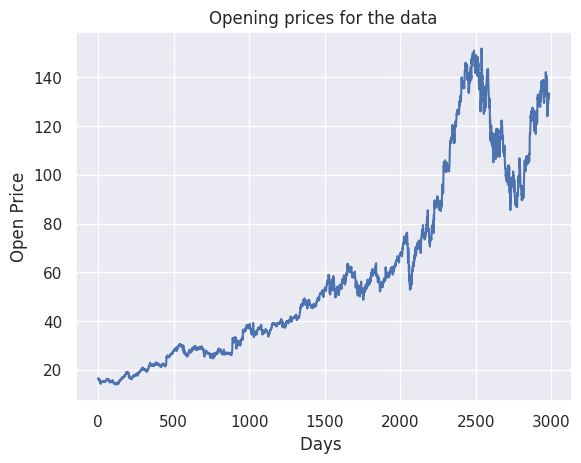

In [11]:
plt.plot(data);
plt.title("Opening prices for the data");
plt.xlabel("Days ")
plt.ylabel("Open Price")
plt.show()

#Normalization / Feature Scaling

In [12]:
from sklearn.preprocessing import MinMaxScaler
# split data in 80%/10%/10% train/validation/test sets
valid_set_size_percentage = 10
test_set_size_percentage = 10

# function for min-max normalization of stock
def normalize_data(df):
    min_max_scaler = MinMaxScaler()
    df = min_max_scaler.fit_transform(df.reshape(-1,1))

    return df, min_max_scaler

def load_data(stock, seq_len):
    data = []

    # create all possible sequences of length seq_len
    for index in range(len(stock) - seq_len):
        data.append(stock[index: index + seq_len])

    data = np.array(data);
    valid_set_size = int(np.round(valid_set_size_percentage/100*data.shape[0]));
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]));
    train_set_size = data.shape[0] - (valid_set_size + test_set_size);


    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]

    x_valid = data[train_set_size:train_set_size+valid_set_size,:-1,:]
    y_valid = data[train_set_size:train_set_size+valid_set_size,-1,:]

    x_test = data[train_set_size+valid_set_size:,:-1,:]
    y_test = data[train_set_size+valid_set_size:,-1,:]

    return [x_train, y_train, x_valid, y_valid, x_test, y_test]

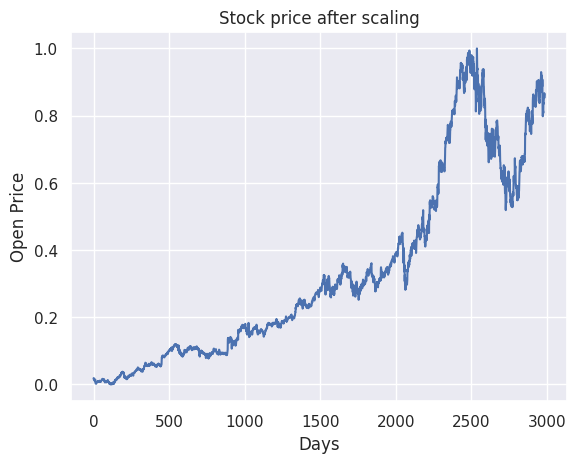

In [13]:
# normalize stock
df_norm = data.copy()
df_norm, min_max_scaler = normalize_data(df_norm)

plt.plot(df_norm)
plt.xlabel("Days")
plt.ylabel("Open Price")
plt.title("Stock price after scaling")
plt.show()

# Creating X_train and y_train from scaled Train data

In [14]:
# create train, test data
seq_len = 20 # choose sequence length
X_train, y_train, X_valid, y_valid,X_test, y_test = load_data(df_norm, seq_len)
print('x_train.shape = ',X_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_valid.shape = ',X_valid.shape)
print('y_valid.shape = ', y_valid.shape)
print('X_test.shape = ', X_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (2372, 19, 1)
y_train.shape =  (2372, 1)
X_valid.shape =  (297, 19, 1)
y_valid.shape =  (297, 1)
X_test.shape =  (297, 19, 1)
y_test.shape =  (297, 1)


# Creating RNN model

In [15]:
# --- RNN ---
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout

model = Sequential()

# Adding the first RNN layer and Dropout regularisation
model.add(SimpleRNN(units = 50,activation='tanh', return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

# Adding a second RNN layer and Dropout regularisation.
model.add(SimpleRNN(units = 50,activation='tanh', return_sequences = True))
model.add(Dropout(0.2))

# Adding a third RNN layer and Dropout regularisation.
model.add(SimpleRNN(units = 50,activation='tanh', return_sequences = True))
model.add(Dropout(0.2))

# Adding a fourth RNN layer and Dropout regularisation.
model.add(SimpleRNN(units = 50))
model.add(Dropout(0.2))

# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
simple_rnn_history = model.fit(X_train, y_train, epochs = 100, batch_size = 32)


Epoch 1/100
75/75 [==============================] - 16s 91ms/step - loss: 0.3259
Epoch 2/100
75/75 [==============================] - 5s 62ms/step - loss: 0.1119
Epoch 3/100
75/75 [==============================] - 5s 63ms/step - loss: 0.0603
Epoch 4/100
75/75 [==============================] - 7s 95ms/step - loss: 0.0378
Epoch 5/100
75/75 [==============================] - 6s 77ms/step - loss: 0.0236
Epoch 6/100
75/75 [==============================] - 7s 90ms/step - loss: 0.0185
Epoch 7/100
75/75 [==============================] - 5s 62ms/step - loss: 0.0153
Epoch 8/100
75/75 [==============================] - 5s 63ms/step - loss: 0.0120
Epoch 9/100
75/75 [==============================] - 7s 89ms/step - loss: 0.0096
Epoch 10/100
75/75 [==============================] - 5s 68ms/step - loss: 0.0083
Epoch 11/100
75/75 [==============================] - 7s 99ms/step - loss: 0.0070
Epoch 12/100
75/75 [==============================] - 5s 70ms/step - loss: 0.0062
Epoch 13/100
75/75 [====

In [16]:
import math
min_loss = np.min(simple_rnn_history.history["loss"])
RMSE = math.sqrt(min_loss)
RMSE

0.021444718922893086

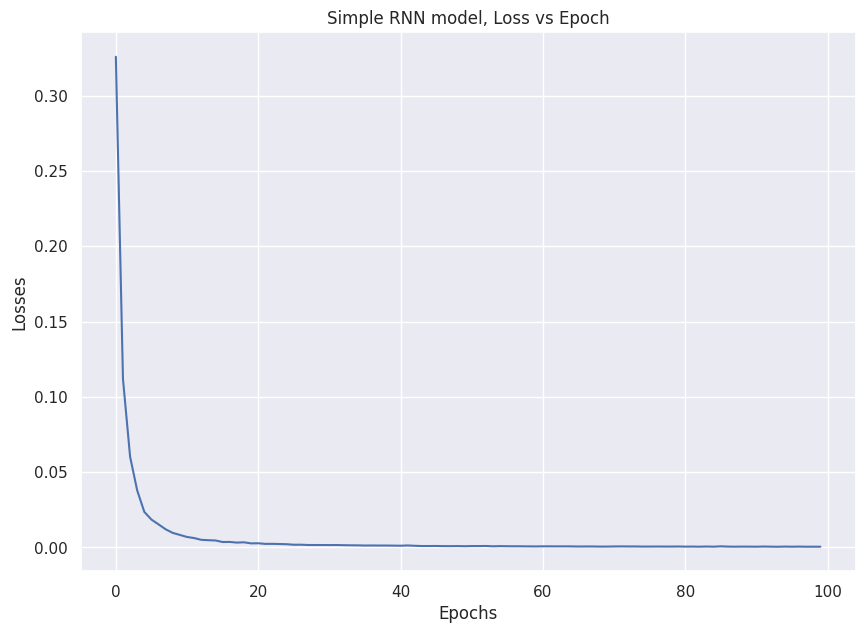

In [17]:
# Plotting Loss vs Epochs
plt.figure(figsize =(10,7))
plt.plot(simple_rnn_history.history["loss"])
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("Simple RNN model, Loss vs Epoch")
plt.show()

In [18]:
predicted_data_valid = model.predict(X_valid)
predicted_data_valid = min_max_scaler.inverse_transform(predicted_data_valid)
y_valid = min_max_scaler.inverse_transform(y_valid)

10/10 [==============================] - 0s 8ms/step


In [19]:
rmse = np.sqrt(np.mean(((predicted_data_valid - y_valid) ** 2)))
print("rmse validation set: ", rmse)

rmse validation set:  3.3986698169053606


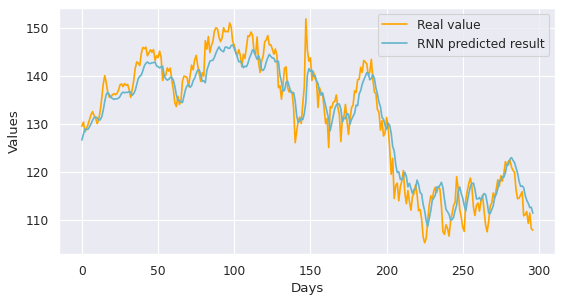

In [20]:
plt.figure(figsize=(8,4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(y_valid,color="orange",label="Real value")
plt.plot(predicted_data_valid,color="c",label="RNN predicted result")
plt.legend()
plt.xlabel("Days")
plt.ylabel("Values")
plt.grid(True)
plt.show()

# Creating LSTM Model

In [21]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

model1 = Sequential()
model1.add(LSTM(10, input_shape=(None,1)))
model1.add(Dense(1))
model1.compile(loss="mean_squared_error",optimizer='Adam')
lstm_history=model1.fit(X_train,y_train,epochs=50, batch_size=1)

Epoch 1/50
2372/2372 [==============================] - 13s 4ms/step - loss: 6.7688e-04
Epoch 2/50
2372/2372 [==============================] - 9s 4ms/step - loss: 1.4387e-04
Epoch 3/50
2372/2372 [==============================] - 9s 4ms/step - loss: 1.1563e-04
Epoch 4/50
2372/2372 [==============================] - 10s 4ms/step - loss: 9.6091e-05
Epoch 5/50
2372/2372 [==============================] - 9s 4ms/step - loss: 8.6895e-05
Epoch 6/50
2372/2372 [==============================] - 9s 4ms/step - loss: 7.8068e-05
Epoch 7/50
2372/2372 [==============================] - 10s 4ms/step - loss: 7.6602e-05
Epoch 8/50
2372/2372 [==============================] - 10s 4ms/step - loss: 6.8813e-05
Epoch 9/50
2372/2372 [==============================] - 9s 4ms/step - loss: 7.2233e-05
Epoch 10/50
2372/2372 [==============================] - 10s 4ms/step - loss: 6.5016e-05
Epoch 11/50
2372/2372 [==============================] - 10s 4ms/step - loss: 6.1648e-05
Epoch 12/50
2372/2372 [============

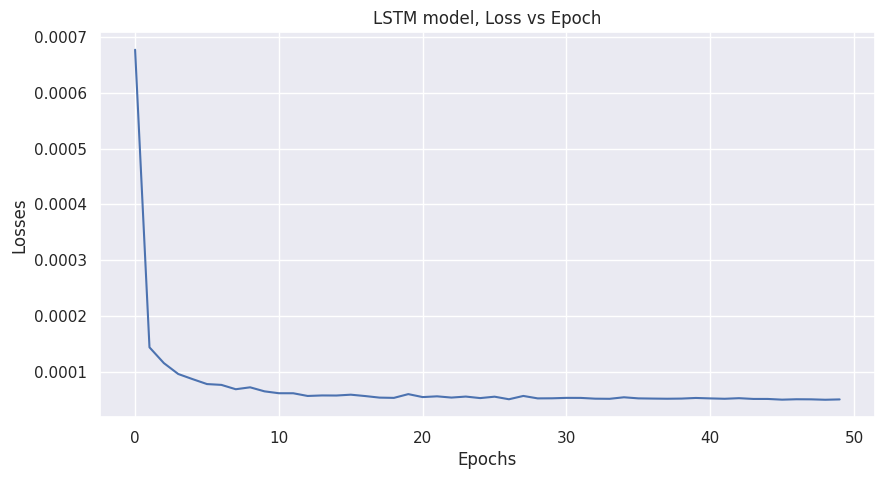

In [22]:
plt.figure(figsize =(10,5))
plt.plot(lstm_history.history["loss"])
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("LSTM model, Loss vs Epoch")
plt.show()

In [23]:
predicted_data_valid2=model1.predict(X_valid)
predicted_data_valid2=min_max_scaler.inverse_transform(predicted_data_valid2)

10/10 [==============================] - 0s 3ms/step


In [24]:
min_loss = np.min(lstm_history.history['loss'])
RMSE = math.sqrt(min_loss)
RMSE

0.007069245943448335

In [25]:
rmse = np.sqrt(np.mean(((predicted_data_valid2 - y_valid) ** 2)))
print("rmse validation set: ", rmse)

rmse validation set:  2.669989504559372


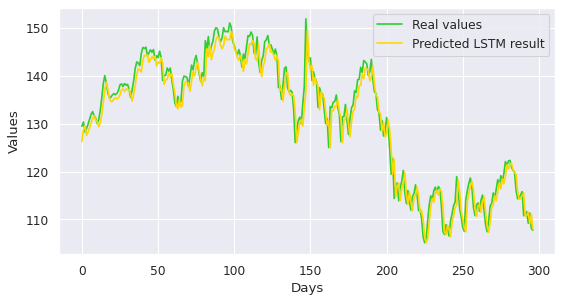

In [26]:
plt.figure(figsize=(8,4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(y_valid,color="LimeGreen",label="Real values")
plt.plot(predicted_data_valid2,color="Gold",label="Predicted LSTM result")
plt.legend()
plt.xlabel("Days")
plt.ylabel("Values")
plt.grid(True)
plt.show()

# Comparetive Study of RNN predictions and LSTM predictions

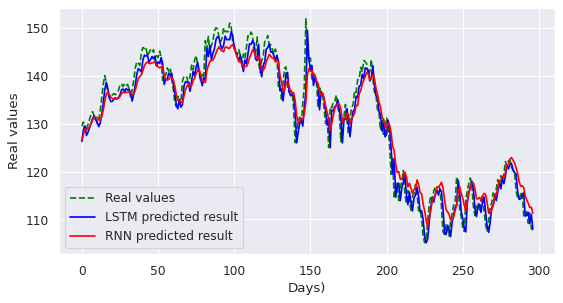

In [27]:
plt.figure(figsize=(8,4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(y_valid,color="green", linestyle='dashed',label="Real values")
plt.plot(predicted_data_valid2,color="blue", label="LSTM predicted result")
plt.plot(predicted_data_valid,color="red",label="RNN predicted result") #
plt.legend()
plt.xlabel("Days)")
plt.ylabel("Real values")
plt.grid(True)
plt.show()

# Time steps = 50

In [28]:
# create train, test data
seq_len_50 = 50 # choose sequence length
X_train_50, y_train_50, X_valid_50, y_valid_50,X_test_50, y_test_50 = load_data(df_norm, seq_len_50)


In [29]:
model_50 = Sequential()
model_50.add(LSTM(10, input_shape=(None,1)))
model_50.add(Dense(1))
model_50.compile(loss="mean_squared_error",optimizer='Adam')
lstm_history_50=model_50.fit(X_train_50,y_train_50,epochs=50, batch_size=1)

Epoch 1/50
2348/2348 [==============================] - 12s 4ms/step - loss: 0.0019
Epoch 2/50
2348/2348 [==============================] - 11s 5ms/step - loss: 2.0360e-04
Epoch 3/50
2348/2348 [==============================] - 11s 5ms/step - loss: 1.5149e-04
Epoch 4/50
2348/2348 [==============================] - 11s 5ms/step - loss: 1.1898e-04
Epoch 5/50
2348/2348 [==============================] - 10s 4ms/step - loss: 1.0606e-04
Epoch 6/50
2348/2348 [==============================] - 12s 5ms/step - loss: 8.7246e-05
Epoch 7/50
2348/2348 [==============================] - 11s 5ms/step - loss: 7.1575e-05
Epoch 8/50
2348/2348 [==============================] - 11s 5ms/step - loss: 6.9701e-05
Epoch 9/50
2348/2348 [==============================] - 10s 4ms/step - loss: 6.1239e-05
Epoch 10/50
2348/2348 [==============================] - 11s 5ms/step - loss: 6.4885e-05
Epoch 11/50
2348/2348 [==============================] - 11s 5ms/step - loss: 5.8777e-05
Epoch 12/50
2348/2348 [===========

In [30]:
predicted_data_valid_50=model_50.predict(X_valid_50)
predicted_data_valid_50=min_max_scaler.inverse_transform(predicted_data_valid_50)
y_valid_50=min_max_scaler.inverse_transform(y_valid_50)

10/10 [==============================] - 0s 3ms/step


In [31]:
min_loss = np.min(lstm_history_50.history['loss'])
RMSE__50 = math.sqrt(min_loss)
RMSE__50

0.007120240509823644

In [32]:
rmse_50 = np.sqrt(np.mean(((predicted_data_valid_50 - y_valid_50) ** 2)))
print("rmse validation set: ", rmse_50)

rmse validation set:  2.6812599199852323


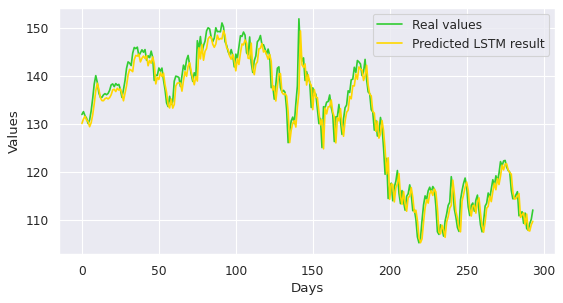

In [33]:
plt.figure(figsize=(8,4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(y_valid_50,color="LimeGreen",label="Real values")
plt.plot(predicted_data_valid_50,color="Gold",label="Predicted LSTM result")
plt.legend()
plt.xlabel("Days")
plt.ylabel("Values")
plt.grid(True)
plt.show()

# Time steps = 100

In [34]:
# create train, test data
seq_len_100 = 100 # choose sequence length
X_train_100, y_train_100, X_valid_100, y_valid_100,X_test_100, y_test_100 = load_data(df_norm, seq_len_100)


In [35]:
model_100 = Sequential()
model_100.add(LSTM(10, input_shape=(None,1)))
model_100.add(Dense(1))
model_100.compile(loss="mean_squared_error",optimizer='Adam')
lstm_history_100=model_100.fit(X_train_100,y_train_100,epochs=50, batch_size=1)

Epoch 1/50
2308/2308 [==============================] - 15s 6ms/step - loss: 0.0032
Epoch 2/50
2308/2308 [==============================] - 13s 6ms/step - loss: 2.4797e-04
Epoch 3/50
2308/2308 [==============================] - 13s 6ms/step - loss: 1.7357e-04
Epoch 4/50
2308/2308 [==============================] - 13s 6ms/step - loss: 1.2856e-04
Epoch 5/50
2308/2308 [==============================] - 13s 6ms/step - loss: 1.0912e-04
Epoch 6/50
2308/2308 [==============================] - 13s 6ms/step - loss: 9.6529e-05
Epoch 7/50
2308/2308 [==============================] - 13s 6ms/step - loss: 7.6656e-05
Epoch 8/50
2308/2308 [==============================] - 13s 6ms/step - loss: 7.1738e-05
Epoch 9/50
2308/2308 [==============================] - 13s 6ms/step - loss: 6.5358e-05
Epoch 10/50
2308/2308 [==============================] - 13s 6ms/step - loss: 6.2447e-05
Epoch 11/50
2308/2308 [==============================] - 13s 6ms/step - loss: 6.1863e-05
Epoch 12/50
2308/2308 [===========

In [36]:
predicted_data_valid_100=model_100.predict(X_valid_100)
predicted_data_valid_100=min_max_scaler.inverse_transform(predicted_data_valid_100)
y_valid_100 = min_max_scaler.inverse_transform(y_valid_100)

10/10 [==============================] - 1s 5ms/step


In [37]:
min_loss = np.min(lstm_history_100.history['loss'])
RMSE = math.sqrt(min_loss)
RMSE

0.007156918531266376

In [38]:
rmse_100 = np.sqrt(np.mean(((predicted_data_valid_100 - y_valid_100) ** 2)))
print("rmse validation set: ", rmse_100)

rmse validation set:  3.0859442788271276


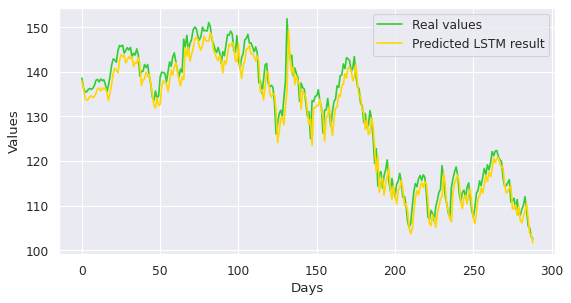

In [39]:
plt.figure(figsize=(8,4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(y_valid_100,color="LimeGreen",label="Real values")
plt.plot(predicted_data_valid_100,color="Gold",label="Predicted LSTM result")
plt.legend()
plt.xlabel("Days")
plt.ylabel("Values")
plt.grid(True)
plt.show()

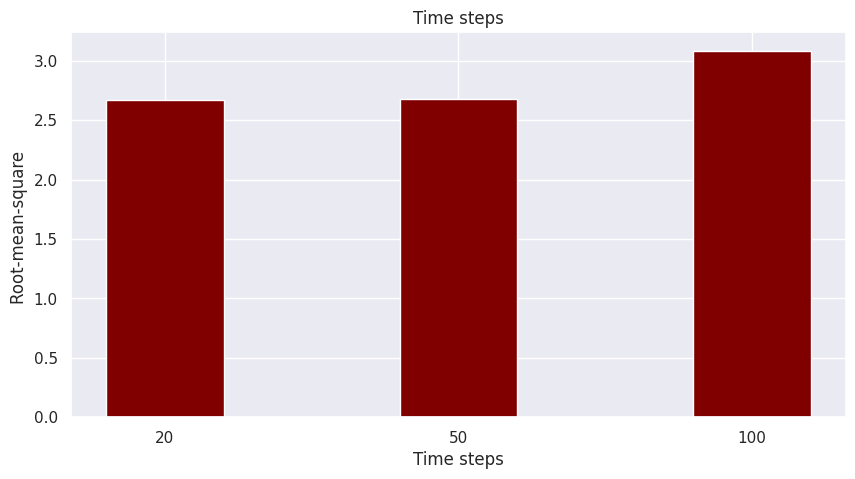

In [40]:
data = {'20':rmse, '50':rmse_50, '100':rmse_100}
courses = list(data.keys())
values = list(data.values())

fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(courses, values, color ='maroon',
        width = 0.4)

plt.xlabel("Time steps")
plt.ylabel("Root-mean-square ")
plt.title("Time steps")
plt.show()

#Applying the best model to test set

In [41]:
predicted_test=model1.predict(X_test)
predicted_test=min_max_scaler.inverse_transform(predicted_test)
y_test = min_max_scaler.inverse_transform(y_test)

10/10 [==============================] - 0s 3ms/step


In [42]:
rmse = np.sqrt(np.mean(((predicted_test - y_test) ** 2)))
print("rmse test set: ", rmse)

rmse test set:  2.2726425762660925


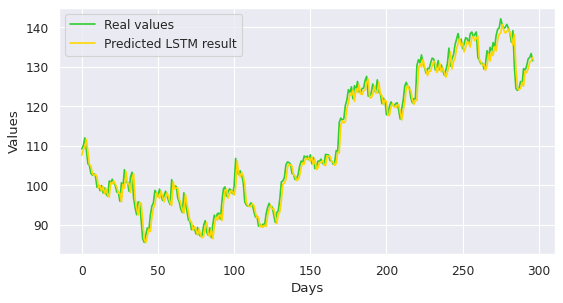

In [43]:
plt.figure(figsize=(8,4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(y_test,color="LimeGreen",label="Real values")
plt.plot(predicted_test,color="Gold",label="Predicted LSTM result")
plt.legend()
plt.xlabel("Days")
plt.ylabel("Values")
plt.grid(True)
plt.show()

# Future price prediction

In [44]:
df.iloc[-1]

Open         1.333600e+02
High         1.341100e+02
Low          1.327700e+02
Close        1.336400e+02
Adj Close    1.336400e+02
Volume       1.640990e+07
Name: 2023-11-13 00:00:00, dtype: float64

In [45]:
X_input = df.iloc[-seq_len:].Open.values               # getting last 20 rows and converting to array
X_input = min_max_scaler.fit_transform(X_input.reshape(-1,1))      # converting to 2D array and scaling
X_input = np.reshape(X_input, (1,seq_len,1))                    # reshaping : converting to 3D array
print("Shape of X_input :", X_input.shape)
X_input

Shape of X_input : (1, 20, 1)


array([[[0.95693773],
        [1.        ],
        [0.943182  ],
        [0.87081319],
        [0.72966484],
        [0.90490453],
        [0.34330174],
        [0.02631593],
        [0.        ],
        [0.02571772],
        [0.13397115],
        [0.07834913],
        [0.33074153],
        [0.30263141],
        [0.37021543],
        [0.47547825],
        [0.49820581],
        [0.55801442],
        [0.44856456],
        [0.55801442]]])

In [46]:
LSTM_prediction = min_max_scaler.inverse_transform(model1.predict(X_input))
print("LSTM prediction, Open price prediction for 2023-11-14 :", LSTM_prediction[0,0])

1/1 [==============================] - 0s 474ms/step
LSTM prediction, Open price prediction for 2023-11-14 : 133.2033
